# Detecció i Classificació d'Expressions Facials

Aquest codi desenvolupa tres models de Deep Learning amb el dataset FER-2013 per classificar emocions facials a partir d’imatges. Inclou:
- Preprocessament i augment de dades
- Construcció, entrenament i anàlisi de tres models:
  - **Model 1**: Estructura CNN bàsica  
  - **Model 2**: Estructura CNN més profunda  
  - **Model 3**: Model millorat amb activacions ELU, regularització L2 i *dropout* progressiu


## Importació de llibreries

In [ ]:
!pip install numpy==1.26.4 mediapipe==0.10.14 --force-reinstall --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 161.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 kB 184.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 132.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 181.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 242.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
import cv2
import kagglehub
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np
import os
import pywt
import random
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


## 1. Preprocessament de les dades

In [ ]:
# Inicialització del mòdul FaceMesh de MediaPipe
mp_face_mesh = mp.solutions.face_mesh

# Funció per alinear la cara i retallar-la eliminant el fons
def align_and_crop_face(image, margin=20):
    # Crear una instància de FaceMesh per a una sola imatge amb refinament dels landmarks
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        # Convertir la imatge de BGR (OpenCV) a RGB (MediaPipe)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb)

        # Si no es detecta cap cara, retornar None
        if not results.multi_face_landmarks:
            return None

        # Obtenir els punts facials (landmarks) de la primera cara detectada
        landmarks = results.multi_face_landmarks[0].landmark

        # Seleccionar punts clau per a l'alineació (ulls esquerre i dret)
        left_eye = landmarks[33]
        right_eye = landmarks[263]

        # Convertir coordenades normalitzades a píxels
        left = np.array([left_eye.x * image.shape[1], left_eye.y * image.shape[0]])
        right = np.array([right_eye.x * image.shape[1], right_eye.y * image.shape[0]])

        # Calcular angle entre els ulls per saber la inclinació de la cara
        dx, dy = right - left
        angle = np.degrees(np.arctan2(dy, dx))
        center = tuple(map(float, ((left + right) / 2)))

        # Calcular matriu de rotació per alinear la cara horitzontalment
        M = cv2.getRotationMatrix2D(center, angle, 1)
        aligned = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC)

        # Tornar a processar la imatge ja alineada per obtenir els nous landmarks
        rgb_aligned = cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB)
        results_aligned = face_mesh.process(rgb_aligned)
        if not results_aligned.multi_face_landmarks:
            return None

        # Obtenir els nous landmarks sobre la imatge alineada
        aligned_landmarks = results_aligned.multi_face_landmarks[0].landmark

        # Calcular la caixa delimitadora (bounding box) que conté tota la cara
        x_coords = [lm.x * aligned.shape[1] for lm in aligned_landmarks]
        y_coords = [lm.y * aligned.shape[0] for lm in aligned_landmarks]

        # Afegir un marge configurable i evitar sortir dels límits de la imatge
        x_min = max(int(min(x_coords)) - margin, 0)
        x_max = min(int(max(x_coords)) + margin, aligned.shape[1])
        y_min = max(int(min(y_coords)) - margin, 0)
        y_max = min(int(max(y_coords)) + margin, aligned.shape[0])

        # Retallar la imatge alineada per obtenir només la cara
        cropped = aligned[y_min:y_max, x_min:x_max]
        return cropped


In [ ]:
# Funció per extreure característiques d’una imatge utilitzant transformada wavelet
def extract_features(image):
    # Redimensionar la imatge a 96x128 píxels
    resized = cv2.resize(image, (96, 128))

    # Convertir a escala de grisos
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

    # Aplicar equalització de l’histograma per millorar el contrast
    equalized = cv2.equalizeHist(gray)

    # Aplicar la descomposició en nivells de la transformada wavelet 2D (db1) fins al nivell 2
    coeffs = pywt.wavedec2(equalized, 'db1', level=2)

    features = []

    # Recórrer cada coeficient de la descomposició
    for coeff in coeffs:
        if isinstance(coeff, tuple):
            # Si és una tupla (detalls horitzontals, verticals i diagonals), aplanar i afegir-los
            for arr in coeff:
                features.extend(arr.flatten())
        else:
            # Si és l'aproximació (primer element), aplanar i afegir-lo també
            features.extend(coeff.flatten())

    # Retornar les característiques com un array de NumPy
    return np.array(features)


In [ ]:
# Funció per carregar i preprocessar un conjunt de dades d’imatges de cares
def load_and_preprocess_dataset(base_dir, target_size=(48, 48)):
    data = []
    labels = []

    # Obtenir les etiquetes (carpetes) ordenades dins del directori base
    classes = sorted(os.listdir(base_dir))

    for label in classes:
        label_path = os.path.join(base_dir, label)

        # Saltar si no és un directori
        if not os.path.isdir(label_path):
            continue

        # Recórrer totes les imatges de la classe actual
        for fname in tqdm(os.listdir(label_path), desc=f"Cargando '{label}'"):
            img_path = os.path.join(label_path, fname)
            img = cv2.imread(img_path)

            # Saltar si no s'ha pogut carregar la imatge
            if img is None:
                continue

            # Alinear i retallar la cara
            processed = align_and_crop_face(img)
            if processed is None:
                continue

            # Redimensionar la cara preprocessada a la mida desitjada
            processed = cv2.resize(processed, target_size)

            # Convertir a escala de grisos
            processed = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)

            # Normalitzar els píxels a l’interval [0, 1]
            processed = processed.astype('float32') / 255.0

            # Afegir una dimensió per canal (necessari per a Keras)
            processed = np.expand_dims(processed, axis=-1)  # (48, 48, 1)

            # Afegir imatge i etiqueta a les llistes
            data.append(processed)
            labels.append(label)

    # Convertir la llista d’imatges a array de NumPy
    data = np.array(data)

    # Codificar les etiquetes com a enters
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)

    # Convertir les etiquetes a codificació one-hot
    labels_onehot = to_categorical(labels_encoded)

    # Retornar les imatges, les etiquetes codificades i els noms de les classes
    return data, labels_onehot, le.classes_


In [ ]:
# Descarreguem les imatges
path = kagglehub.dataset_download("msambare/fer2013")


In [ ]:
# Definim els camins cap a les carpetes de dades d'entrenament i de test
train_dir = os.path.join(path, "train")
test_dir = os.path.join(path, "test")

# Carreguem i processem les dades
X_train, y_train, class_names = load_and_preprocess_dataset(train_dir)
X_test, y_test, _ = load_and_preprocess_dataset(test_dir)

print("Dades carregades:")
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Classes:", class_names)


Cargando 'angry':   0%|          | 0/958 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Cargando 'surprise': 100%|██████████| 831/831 [00:46<00:00, 17.91it/s]

Datos cargados:
X_train shape: (26317, 48, 48, 1)
y_train shape: (26317, 7)
Clases: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


### Visualització de les imatges processades

/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


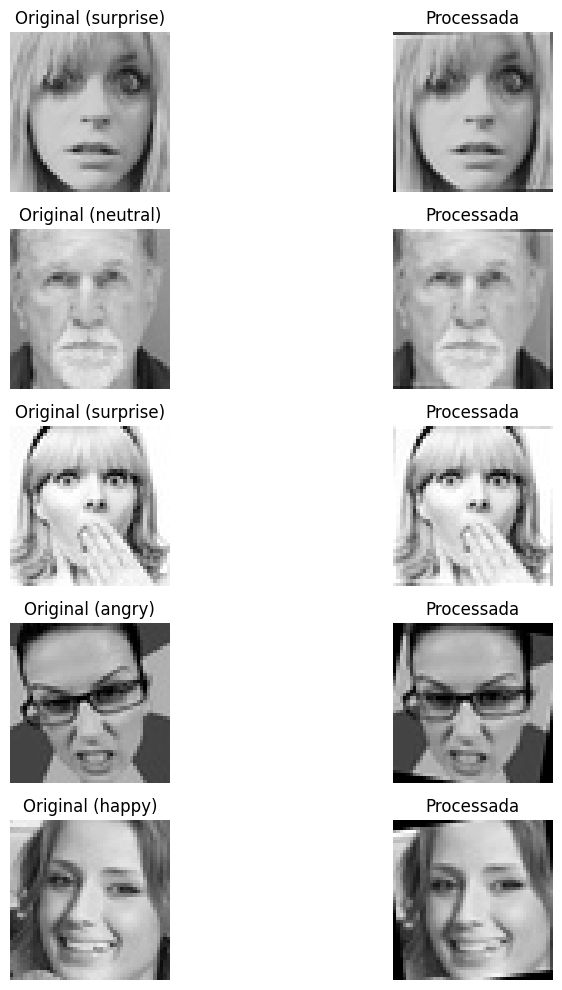

In [ ]:
# Mostra comparació entre imatges originals i processades
def mostrar_comparacions(base_dir, n=5, target_size=(48, 48)):
    classes = sorted(os.listdir(base_dir))
    mostrades = 0

    plt.figure(figsize=(10, 2 * n))

    while mostrades < n:
        # Tria una classe i una imatge aleatòriament
        classe = random.choice(classes)
        classe_path = os.path.join(base_dir, classe)
        if not os.path.isdir(classe_path):
            continue

        fitxers = os.listdir(classe_path)
        if not fitxers:
            continue

        fitxer = random.choice(fitxers)
        img_path = os.path.join(classe_path, fitxer)
        img = cv2.imread(img_path)

        if img is None:
            continue

        # Processa la imatge
        processed = align_and_crop_face(img)
        if processed is None:
            continue

        processed = cv2.resize(processed, target_size)
        processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
        original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Mostra original i processada
        plt.subplot(n, 2, mostrades * 2 + 1)
        plt.imshow(original_rgb)
        plt.title(f'Original ({classe})')
        plt.axis('off')

        plt.subplot(n, 2, mostrades * 2 + 2)
        plt.imshow(processed)
        plt.title('Processada')
        plt.axis('off')

        mostrades += 1

    plt.tight_layout()
    plt.show()

# Crida la funció amb el directori d'entrenament
mostrar_comparacions(train_dir, n=5)


### Preparació de dades i generació d’imatges augmentades

In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Augmentation en entrenamiento
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Generador para validación y test (sin augmentations)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

# Generadores desde arrays
train_generator = train_datagen.flow(X_train_split, y_train_split, batch_size=64, shuffle=True)
val_generator   = val_datagen.flow(X_val_split, y_val_split, batch_size=64, shuffle=False)
test_generator  = test_datagen.flow(X_test, y_test, batch_size=64, shuffle=False)


## 2. Definició i entrenament del models

### Preparació i eines per a l’entrenament i validació

In [ ]:
y_train_int = np.argmax(y_train, axis=1)

# Calcular els pesos de classe per compensar el desequilibri del dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=y_train_int
)

class_weights_dict = dict(enumerate(class_weights))


In [ ]:
# Early stopping per evitar l'overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
# Funció per avaluar el rendiment del model i mostrar resultats
def avaluar_model(model, history, test_generator, y_test, class_names):

    # --- 1. Gràfiques d'entrenament (precisió i pèrdua) ---
    plt.figure(figsize=(12, 5))

    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenament')
    plt.plot(history.history['val_accuracy'], label='Validació')
    plt.title('Precisió')
    plt.xlabel('Èpoques')
    plt.ylabel('Precisió')
    plt.legend()

    # Pèrdua
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenament')
    plt.plot(history.history['val_loss'], label='Validació')
    plt.title('Pèrdua')
    plt.xlabel('Èpoques')
    plt.ylabel('Pèrdua')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- 2. Avaluació sobre el conjunt de test ---
    print("\n📊 Avaluació sobre test:")
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)
    print(f"→ Precisió: {test_acc:.4f} | Pèrdua: {test_loss:.4f}")

    # --- 3. Prediccions i informe de classificació ---
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("\n📋 Informe de classificació:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # --- 4. Matriu de confusió ---
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Etiqueta predicha')
    plt.ylabel('Etiqueta real')
    plt.title('Matriu de confusió')
    plt.show()


### Model 1: Estructura CNN bàsica

In [ ]:
modelCNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),


    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])


# Compilar el model
modelCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resum del model
modelCNN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 619,783 (2.36 MB)

 Trainable params: 619,399 (2.36 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
historyCNN1 = modelCNN.fit(
    X_train_split, y_train_split,
    validation_data=(X_val_split, y_val_split),
    batch_size=64,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6967 - loss: 0.7151 - val_accuracy: 0.5538 - val_loss: 1.3292
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7204 - loss: 0.6595 - val_accuracy: 0.5483 - val_loss: 1.3203
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7293 - loss: 0.6647 - val_accuracy: 0.5559 - val_loss: 1.3191
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7362 - loss: 0.6218 - val_accuracy: 0.5070 - val_loss: 1.8423
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7489 - loss: 0.5908 - val_accuracy: 0.5389 - val_loss: 1.4921
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7548 - loss: 0.5797 - val_accuracy: 0.5403 - val_loss: 1.4446
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7716 - loss: 0.5487 - val_accuracy: 0.5604 - val_loss: 1.4373
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7970 - loss: 0.4765 - val_accuracy: 0.

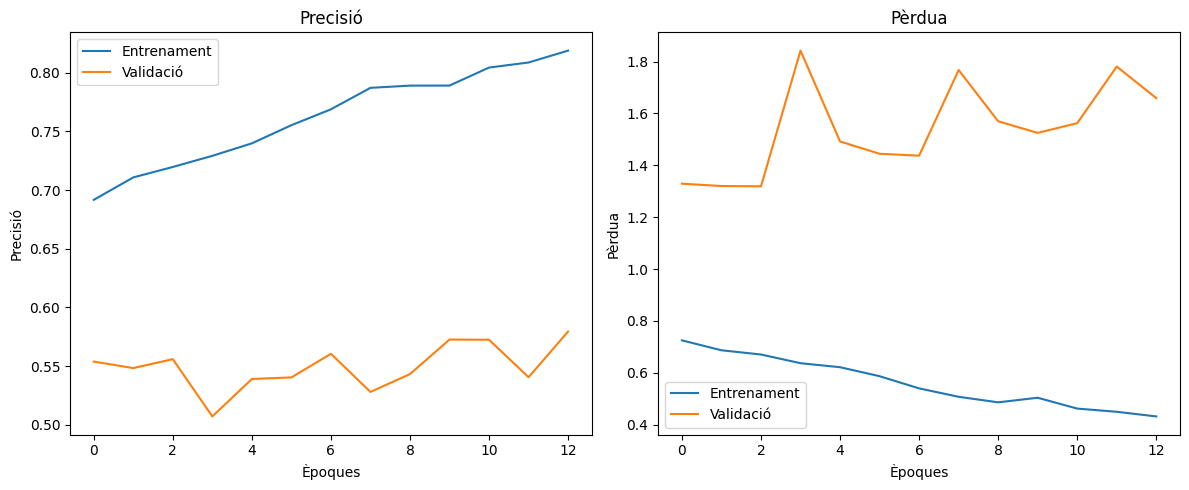


📊 Avaluació sobre test:


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


→ Precisió: 0.5566 | Pèrdua: 1.3030
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

📋 Informe de classificació:
              precision    recall  f1-score   support

       angry       0.49      0.41      0.45       831
     disgust       0.44      0.57      0.50        96
        fear       0.44      0.33      0.38       914
       happy       0.70      0.84      0.76      1703
     neutral       0.52      0.45      0.48      1175
         sad       0.37      0.45      0.40      1086
    surprise       0.76      0.69      0.72       767

    accuracy                           0.56      6572
   macro avg       0.53      0.53      0.53      6572
weighted avg       0.55      0.56      0.55      6572



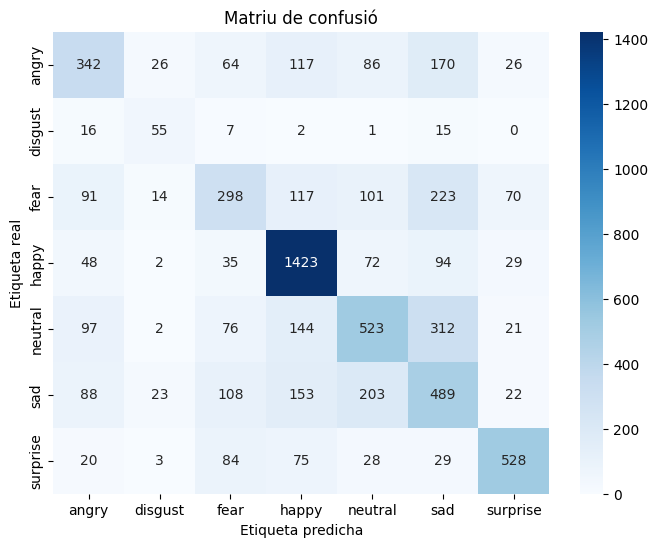

In [ ]:
avaluar_model(modelCNN, historyCNN1, test_generator, y_test, class_names)

#### Entrenament amb data augmentation

In [ ]:
historyCNN2 = modelCNN.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.3116 - loss: 1.9444 - val_accuracy: 0.4052 - val_loss: 1.5427
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.3254 - loss: 1.7010 - val_accuracy: 0.4252 - val_loss: 1.4702
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.3500 - loss: 1.6450 - val_accuracy: 0.4603 - val_loss: 1.4305
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.3557 - loss: 1.6130 - val_accuracy: 0.4605 - val_loss: 1.3884
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.3757 - loss: 1.6169 - val_accuracy: 0.4835 - val_loss: 1.3701
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.3897 - loss: 1.5747 - val_accuracy: 0.4833 - val_loss: 1.3356
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.4090 - loss: 1.5415 - val_accuracy: 0.4930 - val_loss: 1.3335
Epoch 8/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.4019 - loss: 1.5243 - val_accurac

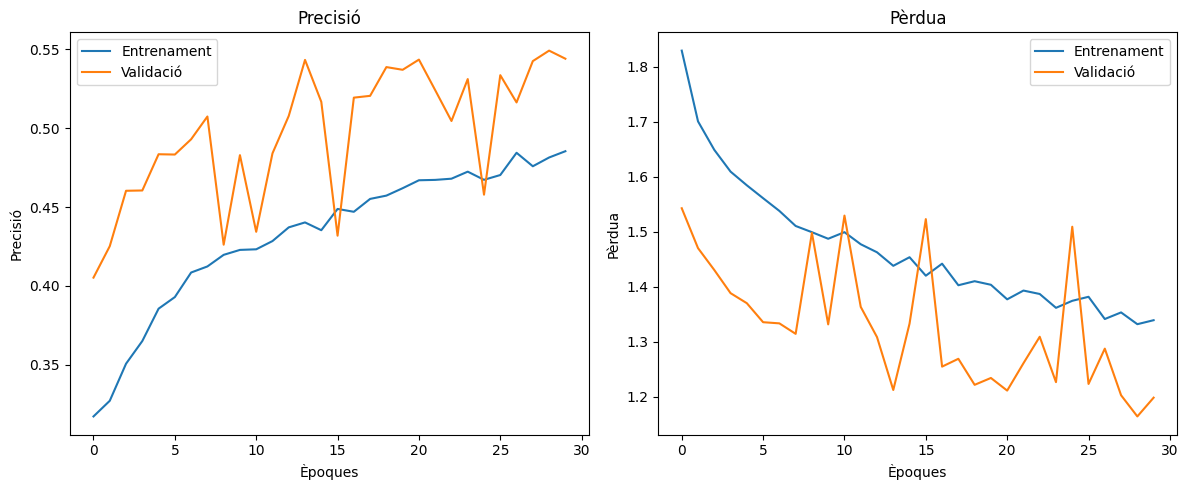


📊 Avaluació sobre test:
→ Precisió: 0.5592 | Pèrdua: 1.1625
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

📋 Informe de classificació:
              precision    recall  f1-score   support

       angry       0.44      0.43      0.44       831
     disgust       0.26      0.65      0.37        96
        fear       0.38      0.20      0.26       914
       happy       0.83      0.82      0.82      1703
     neutral       0.46      0.67      0.54      1175
         sad       0.46      0.27      0.34      1086
    surprise       0.60      0.78      0.68       767

    accuracy                           0.56      6572
   macro avg       0.49      0.55      0.49      6572
weighted avg       0.55      0.56      0.54      6572



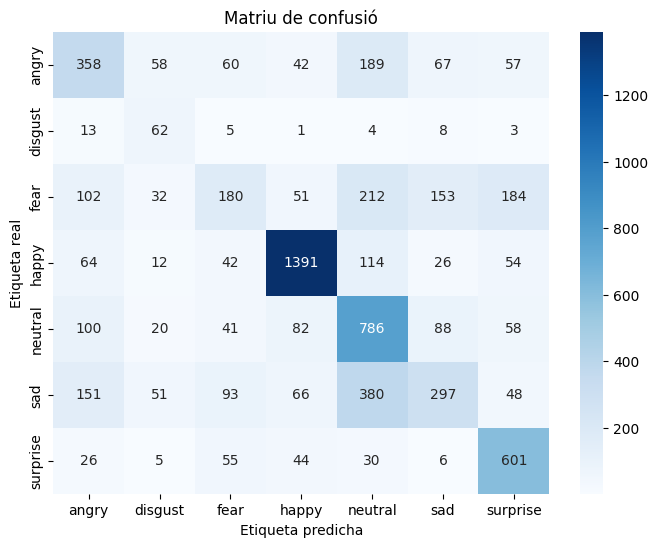

In [ ]:
avaluar_model(modelCNN, historyCNN2, test_generator, y_test, class_names)

### Model 2: Estructura CNN profunda

In [ ]:
def build_fer2013_model(input_shape=(48, 48, 1), num_classes=len(class_names)):
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

modelDeepCNN = build_fer2013_model()
modelDeepCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
historyDeepCNN = modelDeepCNN.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)


Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 38s 73ms/step - accuracy: 0.1606 - loss: 3.4088 - val_accuracy: 0.1554 - val_loss: 1.9346
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.1337 - loss: 1.9521 - val_accuracy: 0.1799 - val_loss: 1.8614
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.1424 - loss: 1.8558 - val_accuracy: 0.1166 - val_loss: 1.8610
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.1363 - loss: 1.8655 - val_accuracy: 0.1938 - val_loss: 1.8839
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.1816 - loss: 1.8539 - val_accuracy: 0.3191 - val_loss: 1.7492
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.2604 - loss: 1.8083 - val_accuracy: 0.3030 - val_loss: 1.6881
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.2954 - loss: 1.7499 - val_accuracy: 0.3830 - val_loss: 1.5943
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.3082 - loss: 1.7424 - 

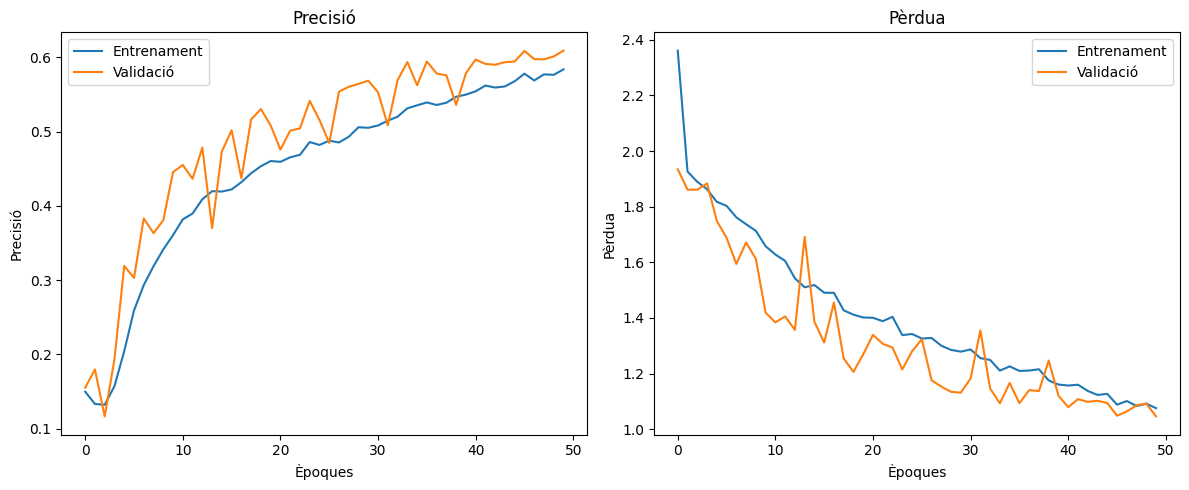


📊 Avaluació sobre test:
→ Precisió: 0.6070 | Pèrdua: 1.0368
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step

📋 Informe de classificació:
              precision    recall  f1-score   support

       angry       0.52      0.48      0.50       831
     disgust       0.44      0.57      0.50        96
        fear       0.56      0.19      0.28       914
       happy       0.89      0.83      0.86      1703
     neutral       0.44      0.81      0.57      1175
         sad       0.48      0.37      0.41      1086
    surprise       0.73      0.78      0.75       767

    accuracy                           0.61      6572
   macro avg       0.58      0.58      0.55      6572
weighted avg       0.62      0.61      0.59      6572



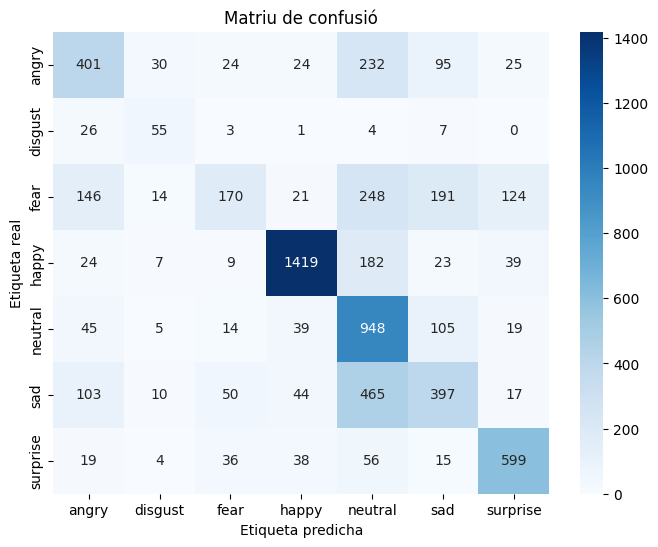

In [ ]:
avaluar_model(modelDeepCNN, historyDeepCNN, test_generator, y_test, class_names)

### Model 3: Optimització amb ELU i regularització L2

In [ ]:
weight_decay = 1e-4  # Factor de regularització L2 per reduir el sobreajustament
num_classes = len(class_names)

model = Sequential()

# Primer bloc convolucional: 2 convolucions + normalització + max pooling + dropout
model.add(Conv2D(64, (4,4), padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay),
                 input_shape=(48, 48, 1)))  # Imatge d'entrada: 48x48 en escala de grisos
model.add(Activation('elu'))  # Funció d’activació ELU
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4), padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))  # Reducció de dimensions
model.add(Dropout(0.2))  # Regularització amb dropout

# Segon bloc convolucional: 1 convolució + normalització + pooling + dropout
model.add(Conv2D(128, (4,4), padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# Tercer bloc convolucional: 2 convolucions + normalització + pooling + dropout
model.add(Conv2D(128, (4,4), padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same',
                 kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Capes de classificació
model.add(Flatten())  # Aplana la sortida convolucional
model.add(Dense(128, activation='linear'))  # Capa densa
model.add(Activation('elu'))
model.add(Dense(num_classes, activation='softmax'))  # Capa de sortida per classificació multiclasse


model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=3e-4), metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)              │ (None, 48, 48, 64)     │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 48, 48, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_46 (Activation)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 24, 24, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_47 (Activation)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 12, 12, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_63          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 12, 12, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_64          │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,315,335 (5.02 MB)

 Trainable params: 1,314,311 (5.01 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Atura l'entrenament si la pèrdua de validació no millora durant 10 èpoques.
# Restaura els pesos del millor punt d'entrenament.

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
# Redueix la taxa d'aprenentatge a la meitat si la pèrdua de validació no millora en 5 èpoques.
# Evita que el model es quedi encallat en un mínim local.

checkpoint = ModelCheckpoint('best_model_elu.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
# Desa el model amb millor precisió en validació en un fitxer.
# Només guarda el model si supera l’anterior (per evitar sobreescriure'l).


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights_dict
)


Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1713 - loss: 2.3874
Epoch 1: val_accuracy improved from -inf to 0.18161, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.1713 - loss: 2.3865 - val_accuracy: 0.1816 - val_loss: 3.2527 - learning_rate: 3.0000e-04
Epoch 2/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2085 - loss: 1.9455
Epoch 2: val_accuracy improved from 0.18161 to 0.37595, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.2087 - loss: 1.9453 - val_accuracy: 0.3759 - val_loss: 1.7180 - learning_rate: 3.0000e-04
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2858 - loss: 1.8775
Epoch 3: val_accuracy improved from 0.37595 to 0.37937, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.2858 - loss: 1.8773 - val_accuracy: 0.3794 - val_loss: 1.6688 - learning_rate: 3.0000e-04
Epoch 4/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3312 - loss: 1.7785
Epoch 4: val_accuracy improved from 0.37937 to 0.41717, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.3313 - loss: 1.7783 - val_accuracy: 0.4172 - val_loss: 1.5862 - learning_rate: 3.0000e-04
Epoch 5/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3696 - loss: 1.7070
Epoch 5: val_accuracy improved from 0.41717 to 0.42800, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.3697 - loss: 1.7069 - val_accuracy: 0.4280 - val_loss: 1.6376 - learning_rate: 3.0000e-04
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3921 - loss: 1.6406
Epoch 6: val_accuracy improved from 0.42800 to 0.43598, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.3922 - loss: 1.6406 - val_accuracy: 0.4360 - val_loss: 1.5393 - learning_rate: 3.0000e-04
Epoch 7/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4235 - loss: 1.5654
Epoch 7: val_accuracy did not improve from 0.43598
329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4235 - loss: 1.5654 - val_accuracy: 0.4012 - val_loss: 1.6055 - learning_rate: 3.0000e-04
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4384 - loss: 1.5248
Epoch 8: val_accuracy did not improve from 0.43598
329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4384 - loss: 1.5248 - val_accuracy: 0.4282 - val_loss: 1.5968 - learning_rate: 3.0000e-04
Epoch 9/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4524 - loss: 1.4736
Epoch 9: val_accuracy improved from 0.43598 to 0.50722, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.4524 - loss: 1.4736 - val_accuracy: 0.5072 - val_loss: 1.3642 - learning_rate: 3.0000e-04
Epoch 10/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4801 - loss: 1.4385
Epoch 10: val_accuracy did not improve from 0.50722
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.4801 - loss: 1.4384 - val_accuracy: 0.5055 - val_loss: 1.3758 - learning_rate: 3.0000e-04
Epoch 11/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4937 - loss: 1.3739
Epoch 11: val_accuracy improved from 0.50722 to 0.52603, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.4937 - loss: 1.3740 - val_accuracy: 0.5260 - val_loss: 1.3361 - learning_rate: 3.0000e-04
Epoch 12/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5127 - loss: 1.3437
Epoch 12: val_accuracy did not improve from 0.52603
329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.5127 - loss: 1.3438 - val_accuracy: 0.4717 - val_loss: 1.5578 - learning_rate: 3.0000e-04
Epoch 13/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5106 - loss: 1.3422
Epoch 13: val_accuracy did not improve from 0.52603
329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5106 - loss: 1.3422 - val_accuracy: 0.5021 - val_loss: 1.4093 - learning_rate: 3.0000e-04
Epoch 14/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5168 - loss: 1.3170
Epoch 14: val_accuracy did not improve from 0.52603
329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.5168 - loss: 1.3169 - val_accuracy: 0.5237 - val_loss: 1.3183 - learning_rate: 3.0

329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.5238 - loss: 1.3124 - val_accuracy: 0.5439 - val_loss: 1.2869 - learning_rate: 3.0000e-04
Epoch 16/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5405 - loss: 1.2909
Epoch 16: val_accuracy did not improve from 0.54388
329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5405 - loss: 1.2908 - val_accuracy: 0.4892 - val_loss: 1.4485 - learning_rate: 3.0000e-04
Epoch 17/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5371 - loss: 1.2747
Epoch 17: val_accuracy did not improve from 0.54388
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5372 - loss: 1.2747 - val_accuracy: 0.5372 - val_loss: 1.2990 - learning_rate: 3.0000e-04
Epoch 18/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5474 - loss: 1.2494
Epoch 18: val_accuracy did not improve from 0.54388
329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.5474 - loss: 1.2494 - val_accuracy: 0.5420 - val_loss: 1.3092 - learning_rate: 3.0

329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - accuracy: 0.5532 - loss: 1.2548 - val_accuracy: 0.5511 - val_loss: 1.2759 - learning_rate: 3.0000e-04
Epoch 20/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5584 - loss: 1.2106
Epoch 20: val_accuracy improved from 0.55110 to 0.57865, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5584 - loss: 1.2106 - val_accuracy: 0.5786 - val_loss: 1.1761 - learning_rate: 3.0000e-04
Epoch 21/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5506 - loss: 1.2187
Epoch 21: val_accuracy did not improve from 0.57865
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5507 - loss: 1.2186 - val_accuracy: 0.5777 - val_loss: 1.2033 - learning_rate: 3.0000e-04
Epoch 22/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5691 - loss: 1.1716
Epoch 22: val_accuracy did not improve from 0.57865
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5691 - loss: 1.1717 - val_accuracy: 0.5767 - val_loss: 1.1776 - learning_rate: 3.0000e-04
Epoch 23/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5782 - loss: 1.1641
Epoch 23: val_accuracy improved from 0.57865 to 0.58587, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.5782 - loss: 1.1642 - val_accuracy: 0.5859 - val_loss: 1.1764 - learning_rate: 3.0000e-04
Epoch 24/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5883 - loss: 1.1207
Epoch 24: val_accuracy did not improve from 0.58587
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.5883 - loss: 1.1208 - val_accuracy: 0.5397 - val_loss: 1.3204 - learning_rate: 3.0000e-04
Epoch 25/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5747 - loss: 1.1719
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 25: val_accuracy did not improve from 0.58587
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.5747 - loss: 1.1718 - val_accuracy: 0.5849 - val_loss: 1.1805 - learning_rate: 3.0000e-04
Epoch 26/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5905 - loss: 1.1095
Epoch 26: val_accuracy improved from 0.58587 to 0.60733, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.5906 - loss: 1.1095 - val_accuracy: 0.6073 - val_loss: 1.1192 - learning_rate: 1.5000e-04
Epoch 27/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6041 - loss: 1.0925
Epoch 27: val_accuracy did not improve from 0.60733
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6041 - loss: 1.0925 - val_accuracy: 0.5967 - val_loss: 1.1448 - learning_rate: 1.5000e-04
Epoch 28/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6081 - loss: 1.0819
Epoch 28: val_accuracy did not improve from 0.60733
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6081 - loss: 1.0819 - val_accuracy: 0.6003 - val_loss: 1.1418 - learning_rate: 1.5000e-04
Epoch 29/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6131 - loss: 1.0624
Epoch 29: val_accuracy did not improve from 0.60733
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6131 - loss: 1.0624 - val_accuracy: 0.6047 - val_loss: 1.1309 - learning_rate: 1.5

329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.6187 - loss: 1.0498 - val_accuracy: 0.6149 - val_loss: 1.1005 - learning_rate: 1.5000e-04
Epoch 32/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6200 - loss: 1.0358
Epoch 32: val_accuracy did not improve from 0.61493
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6200 - loss: 1.0358 - val_accuracy: 0.5952 - val_loss: 1.1492 - learning_rate: 1.5000e-04
Epoch 33/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6287 - loss: 1.0249
Epoch 33: val_accuracy did not improve from 0.61493
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6287 - loss: 1.0250 - val_accuracy: 0.6121 - val_loss: 1.0881 - learning_rate: 1.5000e-04
Epoch 34/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6237 - loss: 1.0292
Epoch 34: val_accuracy did not improve from 0.61493
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.6237 - loss: 1.0292 - val_accuracy: 0.6079 - val_loss: 1.1173 - learning_rate: 1.5

329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6294 - loss: 1.0091 - val_accuracy: 0.6178 - val_loss: 1.0785 - learning_rate: 1.5000e-04
Epoch 36/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6281 - loss: 1.0113
Epoch 36: val_accuracy did not improve from 0.61778
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6281 - loss: 1.0113 - val_accuracy: 0.5967 - val_loss: 1.1657 - learning_rate: 1.5000e-04
Epoch 37/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6272 - loss: 1.0088
Epoch 37: val_accuracy did not improve from 0.61778
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6272 - loss: 1.0088 - val_accuracy: 0.6079 - val_loss: 1.1261 - learning_rate: 1.5000e-04
Epoch 38/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6317 - loss: 1.0056
Epoch 38: val_accuracy improved from 0.61778 to 0.61797, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.6317 - loss: 1.0056 - val_accuracy: 0.6180 - val_loss: 1.1022 - learning_rate: 1.5000e-04
Epoch 39/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6306 - loss: 1.0042
Epoch 39: val_accuracy did not improve from 0.61797
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6306 - loss: 1.0042 - val_accuracy: 0.6161 - val_loss: 1.0911 - learning_rate: 1.5000e-04
Epoch 40/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6405 - loss: 0.9779
Epoch 40: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 40: val_accuracy did not improve from 0.61797
329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - accuracy: 0.6405 - loss: 0.9780 - val_accuracy: 0.6115 - val_loss: 1.1368 - learning_rate: 1.5000e-04
Epoch 41/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6364 - loss: 0.9716
Epoch 41: val_accuracy improved from 0.61797 to 0.63051, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.6364 - loss: 0.9716 - val_accuracy: 0.6305 - val_loss: 1.0545 - learning_rate: 7.5000e-05
Epoch 42/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6441 - loss: 0.9589
Epoch 42: val_accuracy did not improve from 0.63051
329/329 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.6441 - loss: 0.9590 - val_accuracy: 0.6250 - val_loss: 1.0642 - learning_rate: 7.5000e-05
Epoch 43/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6386 - loss: 0.9531
Epoch 43: val_accuracy did not improve from 0.63051
329/329 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.6386 - loss: 0.9531 - val_accuracy: 0.6237 - val_loss: 1.0773 - learning_rate: 7.5000e-05
Epoch 44/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6443 - loss: 0.9568
Epoch 44: val_accuracy did not improve from 0.63051
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6443 - loss: 0.9568 - val_accuracy: 0.6294 - val_loss: 1.0600 - learning_rate: 7.5

329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6466 - loss: 0.9478 - val_accuracy: 0.6307 - val_loss: 1.0655 - learning_rate: 7.5000e-05
Epoch 46/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6532 - loss: 0.9251
Epoch 46: val_accuracy improved from 0.63070 to 0.63602, saving model to best_model_elu.h5


329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6532 - loss: 0.9251 - val_accuracy: 0.6360 - val_loss: 1.0505 - learning_rate: 7.5000e-05
Epoch 47/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6503 - loss: 0.9466
Epoch 47: val_accuracy did not improve from 0.63602
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.6503 - loss: 0.9465 - val_accuracy: 0.6339 - val_loss: 1.0583 - learning_rate: 7.5000e-05
Epoch 48/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6535 - loss: 0.9182
Epoch 48: val_accuracy did not improve from 0.63602
329/329 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.6535 - loss: 0.9182 - val_accuracy: 0.6347 - val_loss: 1.0572 - learning_rate: 7.5000e-05
Epoch 49/50
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6536 - loss: 0.9241
Epoch 49: val_accuracy did not improve from 0.63602
329/329 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6536 - loss: 0.9242 - val_accuracy: 0.6334 - val_loss: 1.0679 - learning_rate: 7.5

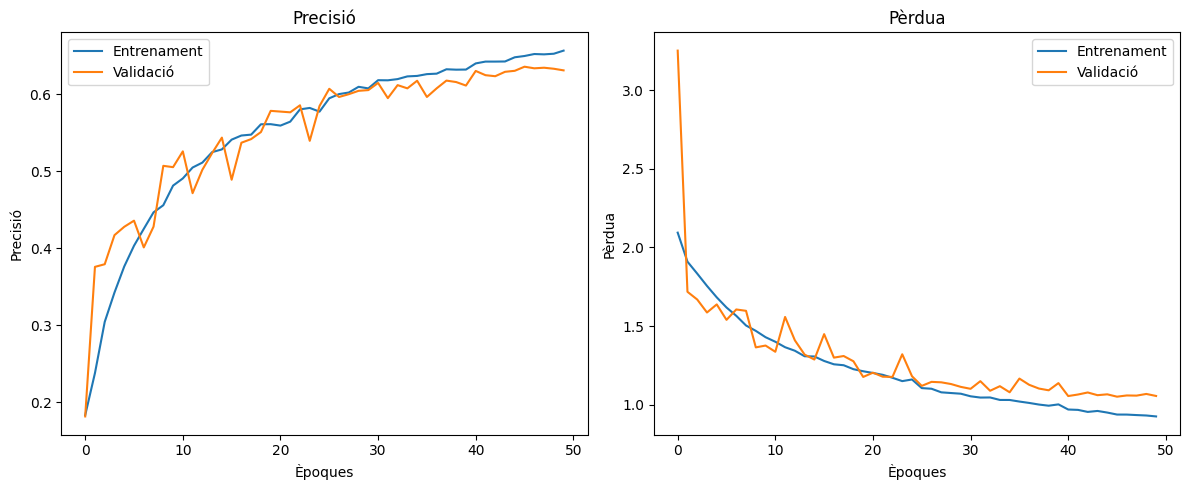


📊 Avaluació sobre test:
→ Precisió: 0.6365 | Pèrdua: 1.0650
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

📋 Informe de classificació:
              precision    recall  f1-score   support

       angry       0.50      0.57      0.53       831
     disgust       0.49      0.69      0.57        96
        fear       0.50      0.31      0.38       914
       happy       0.89      0.84      0.86      1703
     neutral       0.53      0.70      0.60      1175
         sad       0.53      0.45      0.49      1086
    surprise       0.73      0.82      0.77       767

    accuracy                           0.64      6572
   macro avg       0.60      0.62      0.60      6572
weighted avg       0.64      0.64      0.63      6572



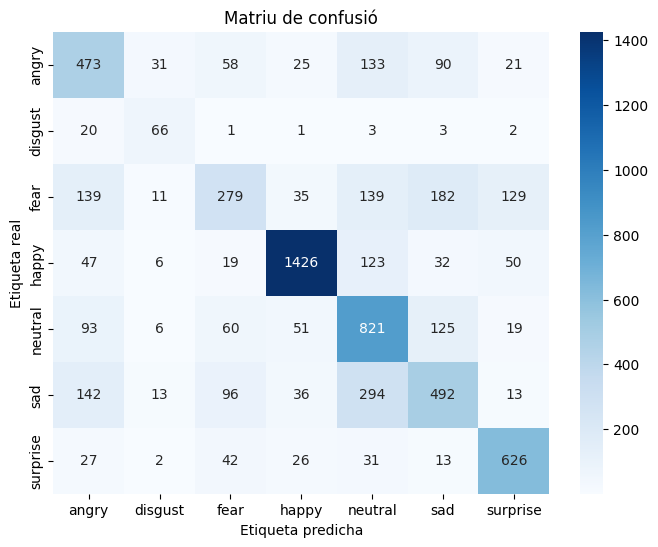

In [ ]:
# Carreguem i avaluem el millor model
best_model = load_model('best_model_elu.h5')
avaluar_model(best_model, history, test_generator, y_test, class_names)
